### Punto 2

In [5]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [6]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        # Tarea
        self.Ep = 0
        self.L = np.zeros(len(t))
        self.VEp = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            self.Ep = (1/4)*self.K*compresion**4
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        # Agregados para la tarea:
        self.L[i] = np.cross(self.r,self.m*self.v)
        self.VEp[i] = self.Ep
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale]

    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]

    def GetPotential(self, scale=1):
        return self.VEp[::scale]
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i]
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i]

In [7]:
def GetParticles(N,t):
    
    Particles = []

    for i in range(N):
        r = np.random.uniform(-20, 20, 2)
        v = np.random.uniform(-5, 5, 2)
        a = np.array([0.,0.])
        p = Particle(r,v,a,t,m=1,radius=2,Id=i)
        Particles.append(p)
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [8]:
dt = 0.001
tmax = 5
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [9]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [10]:
Particles = RunSimulation(t,Particles)

Running simulation:   2%|▏         | 95/5000 [00:00<00:05, 941.31 Steps/s]

Running simulation: 100%|██████████| 5000/5000 [00:05<00:00, 993.22 Steps/s] 


In [11]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

# A) Grafique el momento lineal total en x (px) en función del tiempo. Se debería conservar

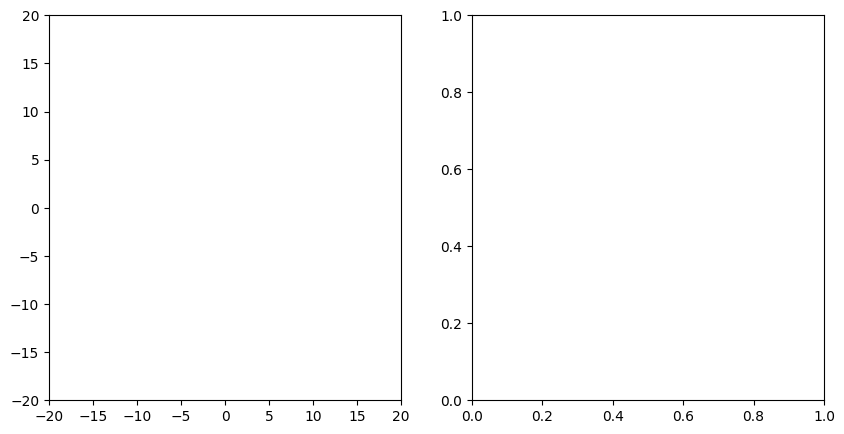

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

# B) Grafique el momento lineal total en y (py) en función del tiempo. Se debería conservar

In [13]:
MomentumT = Particles[0].GetMomentum(scale)

In [14]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

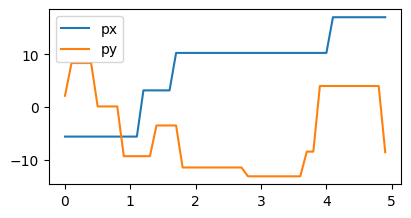

In [15]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

# C) Teóricamente muestre que la fuerza de contacto es conservativa. Encuentre la energía potencial.
En este caso partimos de la ecuación para la fuerza de contacto entre dos esferas
$$
\begin{align*}
\vec{ f }(\vec{r}_1,\vec{r}_2) = K[R1 + R2 - |\vec{r}_1-\vec{r}_2|]^3\hat{n}
\end{align*}
$$
Ahora bien, poniendo esta ecuación en cordenadas polares centradas en una de estas particulas (para que valgan 0 sus parametros) nos queda:
$$
\vec{f}(x,y)=K[R1 + R2 - \sqrt{x^2 + y^2}]^3\left(\frac{\vec{x}_i}{\sqrt{x^2+y^2}},\frac{\vec{y}_i}{\sqrt{x^2+y^2}},0\right)
$$

Ahora bien, si sacamos el rotacional de esta ecuación. nos daremos cuenta de que este es nulo. por lo tanto esta fuerza es conservativa.

Ahora bien. para la ecuación original tomemos $[R1 + R2 - |\vec{r}_1-\vec{r}_2|] = r$. Ahora, desarrollemos de la siguiente manera:
$$
\begin{align*}
\vec{f}(r) = Kr^3\hat{n}\\
\int_r^0 \vec{f}(r)dr = K \frac{r^4}{4}\\
\end{align*}
$$

Ahora bien, tambien tenemos que definir una función potencial que en este caso tomaremos que la función potencial $U$ para la fuerza $f$ es
$$
f = -\nabla U = - \frac{\partial U (r)}{\partial r}\hat{r}
$$

por lo tanto, terminamos con
$$
-\frac{\partial K \frac{r^4}{4}}{\partial r}\hat{r} = -Kr^3\hat{n}=\vec{f}
$$

por lo tanto, esta es la función que buscamos

# D) rafique la energía cinética total en función del tiempo. Se conserva?
La energia cinetica se conserva en los estados pos y pre choque pero no se conserva durante el choque (pues en ese caso obtenemos algo de energia potencial representada por la rigides de la propia esfera) Puede mirar la grafica de la figura 1 en donde esta esta grafica solicitada.

# E) Grafique la energía potencial total en función del tiempo. ¿Qué significa que el potencial sea positivo?

Dado que el potencial es positivo y tomando en cuenta la definición de potencial que se dio en el punto *C* significaria que las particulas estan en un estado no ligado y por lo tanto que se repelerian.

# F) Grafique la energía mecánica total en funcion del tiempo. Se conserva? Explique a nivel físico y a nivel del método de Euler.

La energia mecanica de manera teorica se deberia conservar por completo. Sin embargo, este no es el caso y no se cumple. Ahora tendriamos que considerar las posibles causas de este proceso. En el primer caso la energia total se podria conservar pero se tendria que considerar las posibles perdidas que se tuvieron en forma de calor y deformaciónes 

# G) Se cumple el teorema del trabajo y la energía en su simulación? Argumente.

Dado que para el teorema de la energia y el trabajo necesitariamos que se cumpla:
$$
\Delta K = - \Delta W
$$

y teniendo este resultado desde puntos anteriores (en especifico el *C*) podemos decir que se cumple. Aunque debemos considerar de las discrepancias que tenemos y de las que hablamos en el punto directamente anterior.

# H) Calcule y grafique el momento angular en el eje z (Lz). Se conserva?

Dado que no hay torques externos. El momento angular debe conservarse.

In [16]:
MomentoAngular = 0
EnergiaCinetica = 0
EnergiaPotencial = 0
for particula in Particles:
    MomentoAngular = np.add(MomentoAngular, particula.GetAngularMomentum(scale))
    EnergiaCinetica += particula.GetKineticEnergy(scale)
    EnergiaPotencial += particula.GetPotential(scale)/2
EnergiaMecanica = EnergiaCinetica + EnergiaPotencial

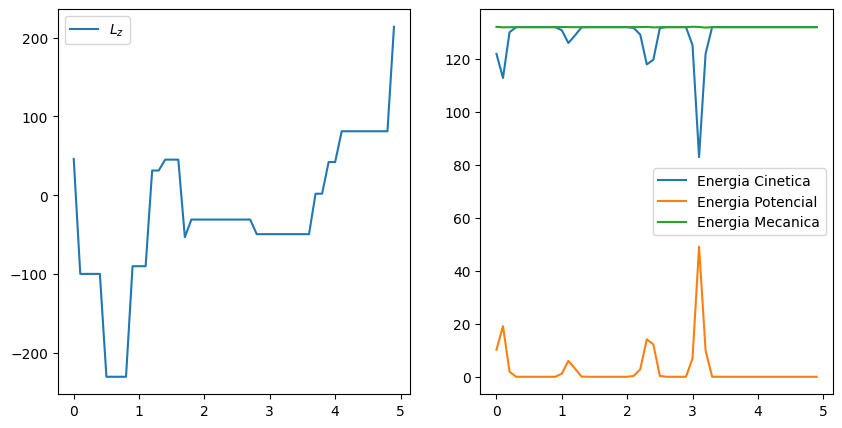

In [17]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(121)
ax5 = fig4.add_subplot(122)

ax4.plot(t1,MomentoAngular,label="$L_z$")
ax4.plot(0,0)

ax5.plot(t1,EnergiaCinetica,label='Energia Cinetica')
ax5.plot(t1,EnergiaPotencial,label='Energia Potencial')
ax5.plot(t1,EnergiaMecanica,label='Energia Mecanica')

ax4.legend()
ax5.legend()

# I) Si este sistema que se mueve en 2D se extendiera a 3D, las partículas se mantendrían en el mismo plano de movimiento o se moveran en todo el volumen?

Creo que si ocuparia todo el volumen. Quizas en una situación demasiado extraña en donde ninguna colision se diera este seguiria exactamente las mismas trayectorias que las que tiene en 2D. Sin embargo, una vez se tiene un choque la propia geometria de las particulas favoreceria los movimientos en direcciones que en este momento le resultan imposibles. Es como cuando uno tira dos pelotas a que se choquen entre si. Si estan sobre una mesa (de billar por ejemplo lo mas probable es que sigan en ese mismo plano. Pero si estan en el aire lo mas probable es que varien de dirección y se muevan en todos los ejes de libertad que tengan